# Sea ice proxy comparison

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import pandas as pd
import xarray as xr

from scipy import signal
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1,CMAP=plt.cm.RdBu_r,colorbar=True,extent=True):
#    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    var1=VAR1
    lon1=LON
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1,1,1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=CMAP, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [4]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [5]:
plt.rcParams['figure.dpi']=300

In [6]:
anom_start = 1979
anom_end = 2000

## Load reconstructions: 

In [7]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file_ccsm4 = 'Brennan_and_Hakim_2021_CCSM4_model_prior_reconstructions_nh.nc'

recon_data_ccsm4 = xr.open_dataset(recon_dir+recon_file_ccsm4)

In [8]:
sia_reg_anom_ccsm4 = recon_data_ccsm4.si_area_regional_anomalies.values
sie_ensmn_anom_allit_ccsm4 = recon_data_ccsm4.si_area_ensemble_mean_anomalies.values
sie_97_5_allit_ccsm4 = recon_data_ccsm4.si_extent_97_5_percentiles.values
sie_2_5_allit_ccsm4 = recon_data_ccsm4.si_extent_2_5_percentiles.values

regions = recon_data_ccsm4.regions.values
recon_years = recon_data_ccsm4.time.values
recon_lat = recon_data_ccsm4.lat.values
recon_lon = recon_data_ccsm4.lon.values

## Load Walsh regional data: 

In [9]:
walsh_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Walsh2016/walsh_comparison/'
walsh_file = 'Walsh_annual_regional_means_sia_sie_km2.npz'
walsh_all_file = 'Walsh_annual_all_regional_means_sia_sie_km2.npz'

walsh_ds = np.load(walsh_dir+walsh_file)

In [10]:
walsh_time = walsh_ds['Walsh_years']
walsh_ind = np.where((walsh_time>=anom_start)&(walsh_time<=anom_end))

walsh_greenland_sia = walsh_ds['Greenland_sea_sia_anmn'] - np.nanmean(walsh_ds['Greenland_sea_sia_anmn'][walsh_ind])
walsh_hudbay_sia = walsh_ds['Hudson_bay_sea_sia_anmn'] - np.nanmean(walsh_ds['Hudson_bay_sea_sia_anmn'][walsh_ind])
walsh_barents_sia = walsh_ds['Barents_sea_sia_anmn'] - np.nanmean(walsh_ds['Barents_sea_sia_anmn'][walsh_ind])
walsh_canarch_sia = walsh_ds['CanArch_sea_sia_anmn'] - np.nanmean(walsh_ds['CanArch_sea_sia_anmn'][walsh_ind])
walsh_chukchi_sia = walsh_ds['Chukchi_sea_sia_anmn'] - np.nanmean(walsh_ds['Chukchi_sea_sia_anmn'][walsh_ind])

walsh_greenland_sie = walsh_ds['Greenland_sea_sie_anmn'] - np.nanmean(walsh_ds['Greenland_sea_sie_anmn'][walsh_ind])
walsh_hudbay_sie = walsh_ds['Hudson_bay_sea_sie_anmn'] - np.nanmean(walsh_ds['Hudson_bay_sea_sie_anmn'][walsh_ind])
walsh_barents_sie = walsh_ds['Barents_sea_sie_anmn'] - np.nanmean(walsh_ds['Barents_sea_sie_anmn'][walsh_ind])
walsh_canarch_sie = walsh_ds['CanArch_sea_sie_anmn'] - np.nanmean(walsh_ds['CanArch_sea_sie_anmn'][walsh_ind])
walsh_chukchi_sie = walsh_ds['Chukchi_sea_sie_anmn'] - np.nanmean(walsh_ds['Chukchi_sea_sie_anmn'][walsh_ind])

In [11]:
walsh_all_ds = np.load(walsh_dir+walsh_all_file)
walsh_ind = np.where((walsh_time>=anom_start)&(walsh_time<=anom_end))

walsh_years = walsh_all_ds['Walsh_years']
walsh_regional_sia = {}
walsh_regional_sie = {}

walsh_regional_sia['Beaufort Sea'] = walsh_all_ds['Beaufort_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Beaufort_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Chukchi Sea'] = walsh_all_ds['Chukchi_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Chukchi_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['East Siberian Sea'] = walsh_all_ds['Siberian_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Siberian_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Laptev Sea'] = walsh_all_ds['Laptev_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Laptev_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Kara Sea'] = walsh_all_ds['Kara_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Kara_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Barents Sea'] = walsh_all_ds['Barents_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Barents_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['East Greenland Sea'] = walsh_all_ds['Greenland_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Greenland_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Baffin Bay'] = walsh_all_ds['Baffin_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Baffin_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Canadian Archipelago'] = walsh_all_ds['CanArch_sea_sia_anmn'] - np.nanmean(walsh_all_ds['CanArch_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Hudson Bay'] = walsh_all_ds['Hudson_bay_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Hudson_bay_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Central Arctic'] = walsh_all_ds['Centralarctic_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Centralarctic_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Baltic Sea'] = walsh_all_ds['Baltic_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Baltic_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Bering Sea'] = walsh_all_ds['Bering_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Bering_sea_sia_anmn'][walsh_ind])
walsh_regional_sia['Sea of Okhotsk'] = walsh_all_ds['Okhotsk_sea_sia_anmn'] - np.nanmean(walsh_all_ds['Okhotsk_sea_sia_anmn'][walsh_ind])

In [12]:
walsh_regional_sie['Beaufort Sea'] = walsh_all_ds['Beaufort_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Beaufort_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Chukchi Sea'] = walsh_all_ds['Chukchi_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Chukchi_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['East Siberian Sea'] = walsh_all_ds['Siberian_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Siberian_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Laptev Sea'] = walsh_all_ds['Laptev_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Laptev_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Kara Sea'] = walsh_all_ds['Kara_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Kara_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Barents Sea'] = walsh_all_ds['Barents_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Barents_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['East Greenland Sea'] = walsh_all_ds['Greenland_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Greenland_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Baffin Bay'] = walsh_all_ds['Baffin_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Baffin_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Canadian Archipelago'] = walsh_all_ds['CanArch_sea_sie_anmn'] - np.nanmean(walsh_all_ds['CanArch_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Hudson Bay'] = walsh_all_ds['Hudson_bay_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Hudson_bay_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Central Arctic'] = walsh_all_ds['Centralarctic_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Centralarctic_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Baltic Sea'] = walsh_all_ds['Baltic_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Baltic_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Bering Sea'] = walsh_all_ds['Bering_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Bering_sea_sie_anmn'][walsh_ind])
walsh_regional_sie['Sea of Okhotsk'] = walsh_all_ds['Okhotsk_sea_sie_anmn'] - np.nanmean(walsh_all_ds['Okhotsk_sea_sie_anmn'][walsh_ind])

## Plotting: 

In [13]:
ce_walsh_ccsm4_allregions = {}
corr_walsh_ccsm4_allregions = {}

for r,reg in enumerate(regions): 
    print('Working on '+reg+'...')
    [ce_walsh_ccsm4_allregions[reg],
     corr_walsh_ccsm4_allregions[reg],_,_] = rrutils.find_ce_corr(walsh_regional_sia[reg], 
                                                                  sia_reg_anom_ccsm4[r,:],
                                                                  recon_years,
                                                                  walsh_time,1850,1999)
    
    print('R^2 = '+str(np.round(corr_walsh_ccsm4_allregions[reg]**2,2)))
    print('CE = '+str(np.round(ce_walsh_ccsm4_allregions[reg],2))+'\n')

Working on Sea of Okhotsk...
R^2 = 0.02
CE = -10.96

Working on Bering Sea...
R^2 = 0.25
CE = -0.2

Working on Hudson Bay...
R^2 = 0.17
CE = -0.4

Working on Baffin Bay...
R^2 = 0.0
CE = -2.97

Working on East Greenland Sea...
R^2 = 0.02
CE = -0.6

Working on Barents Sea...
R^2 = 0.12
CE = -0.36

Working on Kara Sea...
R^2 = 0.15
CE = -1.3

Working on Laptev Sea...
R^2 = 0.09
CE = -8.56

Working on East Siberian Sea...
R^2 = 0.07
CE = -1.26

Working on Chukchi Sea...
R^2 = 0.28
CE = 0.03

Working on Beaufort Sea...
R^2 = 0.12
CE = -0.37

Working on Canadian Archipelago...
R^2 = 0.01
CE = -24.03

Working on Central Arctic...
R^2 = 0.01
CE = -6.59



In [14]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


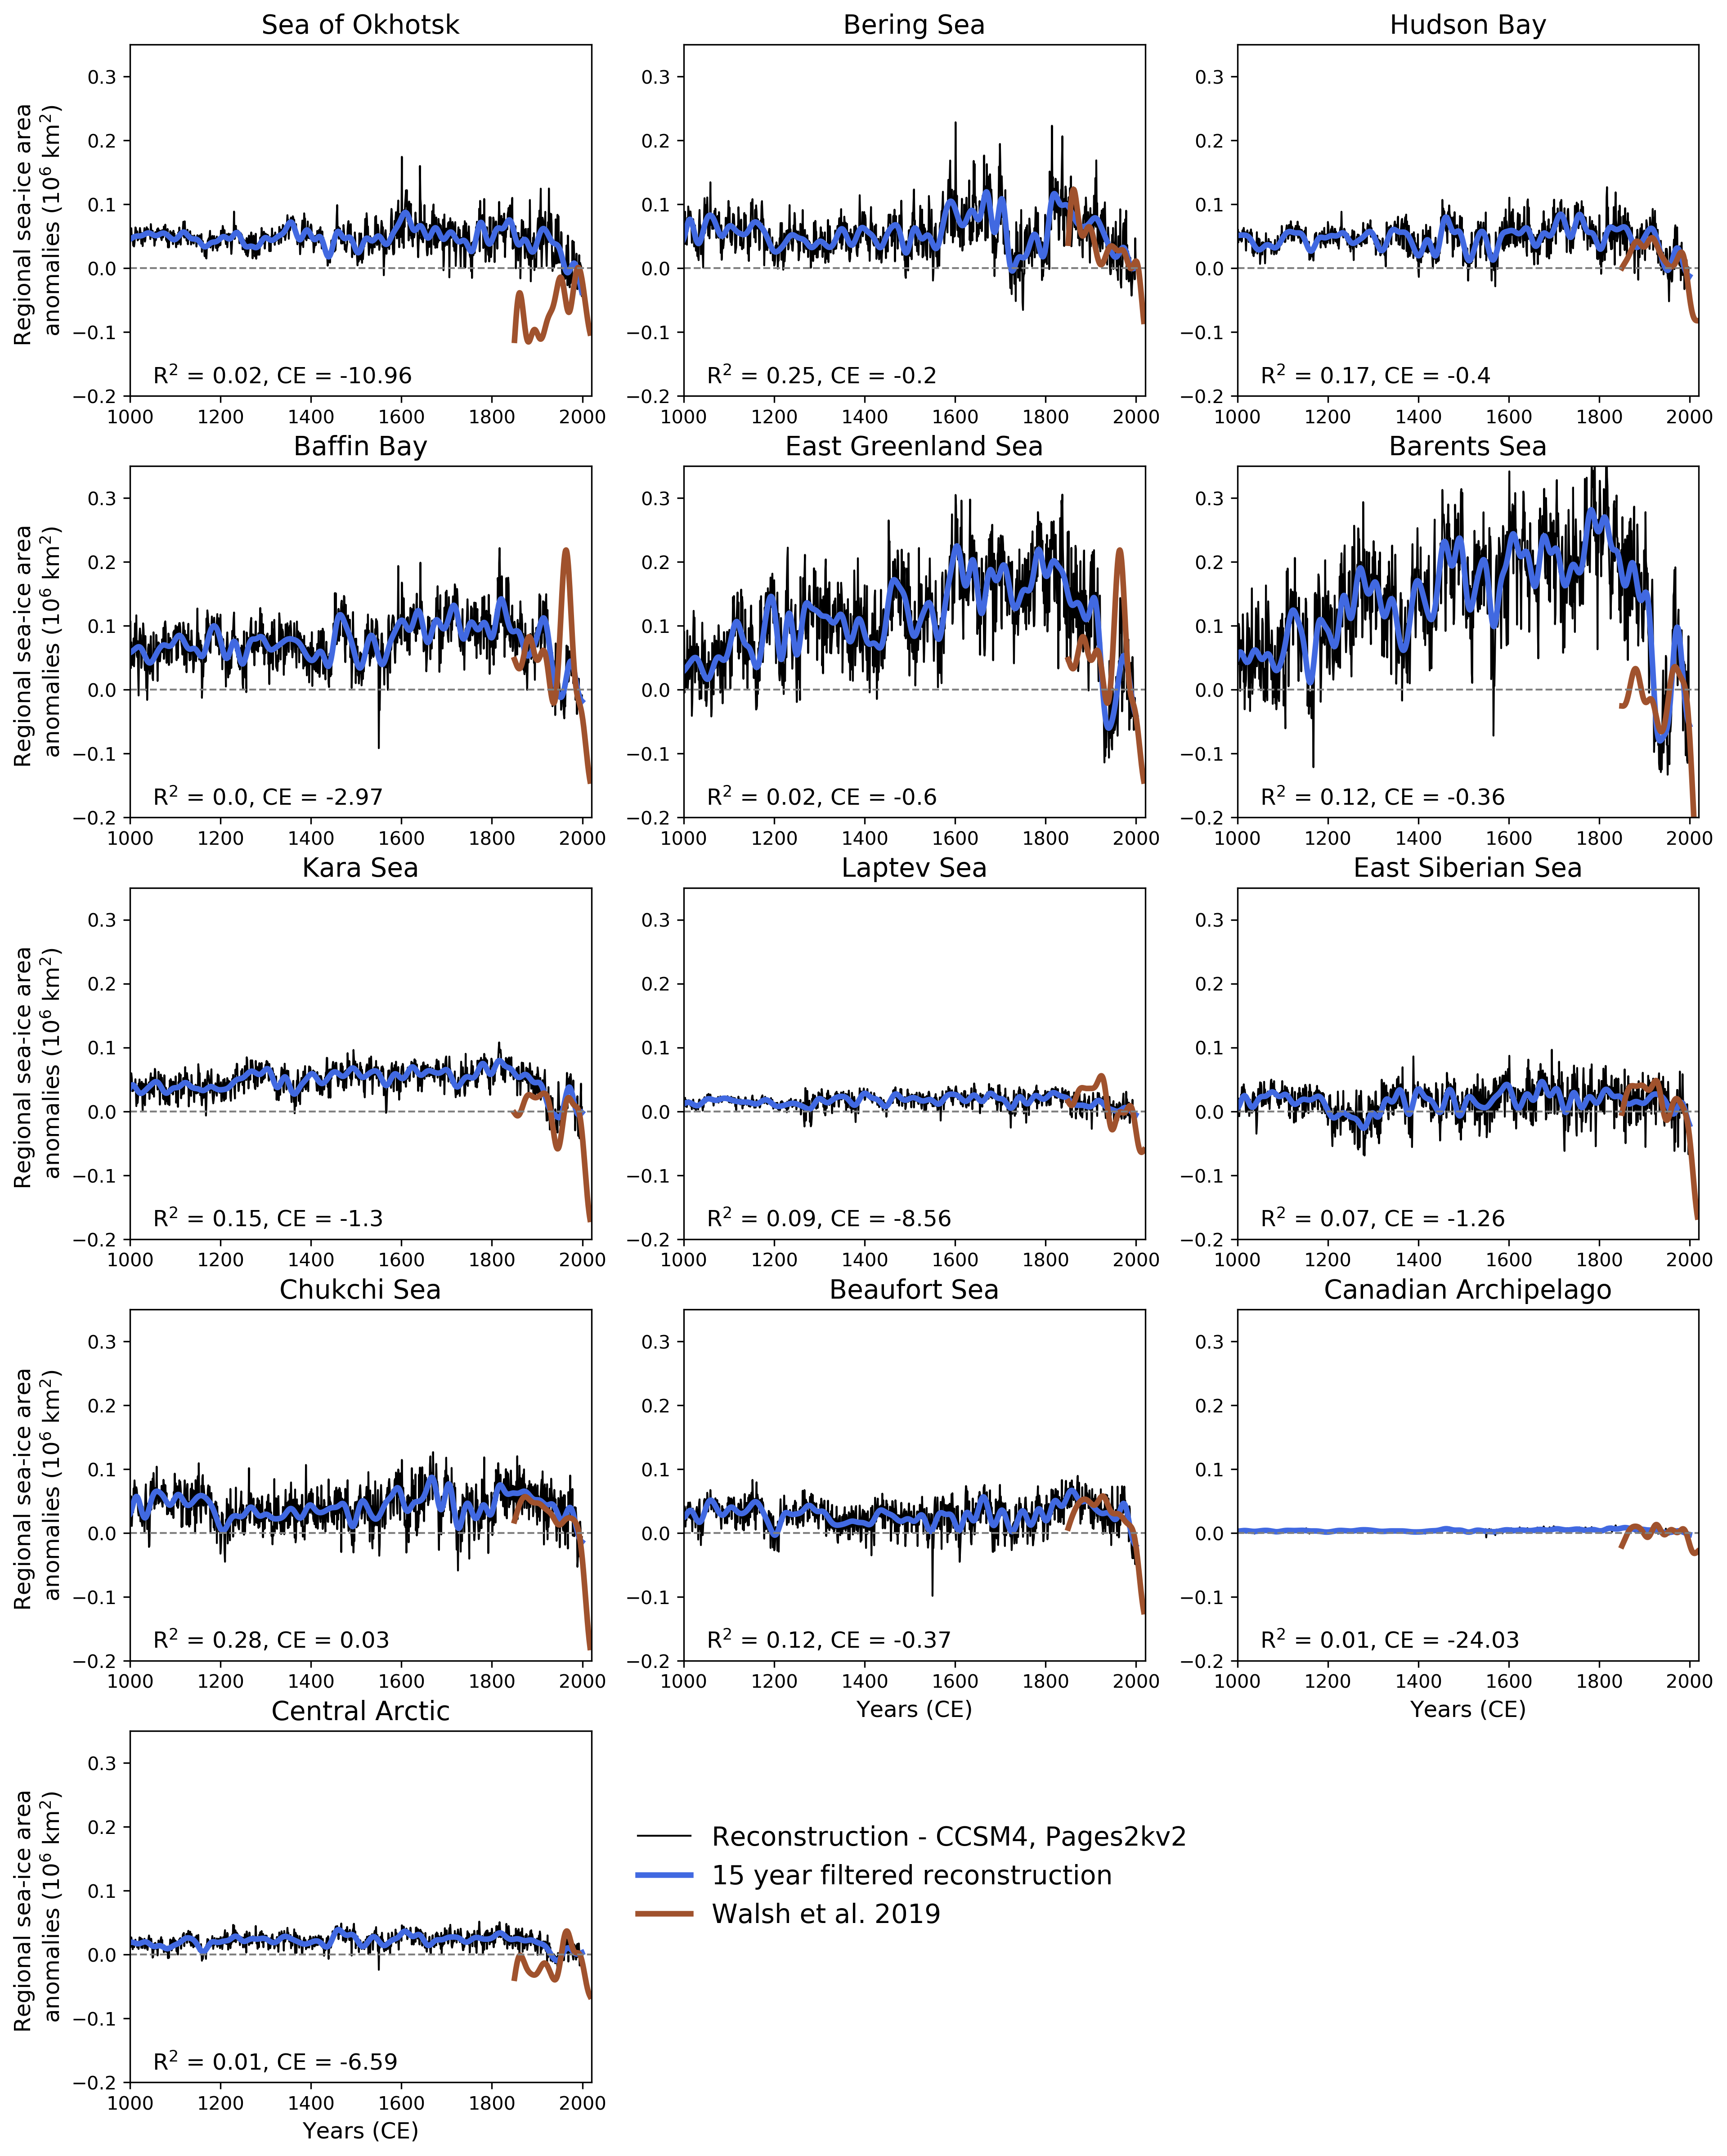

In [15]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax[4,2].set_axis_off()
ax[4,1].set_axis_off()
ax = ax.flatten()


for i,reg in enumerate(regions): 
    walsh_filt15 =  signal.filtfilt(b2,a2,walsh_regional_sia[reg])
    recon_filt15 =  signal.filtfilt(b2,a2,sia_reg_anom_ccsm4[i,:])
    
    ax[i].plot(np.array(recon_years),sia_reg_anom_ccsm4[i,:], color='k', linewidth=1, 
               label='Reconstruction - CCSM4, Pages2kv2')
    ax[i].plot(np.array(recon_years), recon_filt15, color='royalblue', linewidth=3, 
              label = '15 year filtered reconstruction')
    
    ax[i].plot(walsh_years,walsh_filt15, color='sienna',linewidth=3, label = 'Walsh et al. 2019')
    
    ax[i].axhline(0,color='gray', linestyle='--', linewidth=1)
    if i in [0,3,6,9,12]:
        ax[i].set_ylabel('Regional sea-ice area \nanomalies (10$^6$ km$^2$)', fontsize=12)
        
    if i is 12: 
        ax[i].legend(bbox_to_anchor=[1.05,0.8], fontsize=14, frameon=False)
  
    ax[i].set_xlim(1000,2020)
    ax[i].set_ylim(-0.2,0.35)
    ax[i].set_title(reg, fontsize=14)
    ax[i].text(1050, -0.18,('R$^2$ = '+str(np.round(corr_walsh_ccsm4_allregions[reg]**2,2)) + 
               ', CE = '+str(np.round(ce_walsh_ccsm4_allregions[reg],2))), fontsize=12)
    
ax[12].set_xlabel('Years (CE)',fontsize=12)
ax[11].set_xlabel('Years (CE)',fontsize=12)
ax[10].set_xlabel('Years (CE)',fontsize=12)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Regional_comparison_ccsm4_walsh_all_regions.png'
# plt.savefig(savedir+savename)

# Proxy comparisons: 

In [16]:
data_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/si_proxy_records/'

## Halfar et al. 2013 - Canadian Arctic: 

In [17]:
Halfar_file = 'Halfar_etal_2013.csv'

# Site Information
#       Site_Name: Arctic Northwest Atlantic
#       Location: Ocean>Atlantic Ocean>North Atlantic Ocean
#       Northernmost_Latitude: 73.0174
#       Southernmost_Latitude: 55.3983
#       Easternmost_Longitude: -59.8467
#       Westernmost_Longitude: -85.1536
#       Elevation: -17

halfar_ds = pd.read_csv(data_dir+Halfar_file,delimiter = "\t",skiprows=83)
halfar_ds.head()

,age_AD,SIC
0,2010,0.65
1,2009,-0.97
2,2008,0.42
3,2007,1.25
4,2006,0.21


In [18]:
halfar_sic = halfar_ds['SIC'].values
halfar_time = halfar_ds['age_AD'].values

In [19]:
halfar_sic_5ymn = np.zeros(halfar_sic.shape[0]-4)
start = 2

for t in range(halfar_sic_5ymn.shape[0]):
    halfar_sic_5ymn[t] = np.nanmean(halfar_sic[start-2:start+3],axis=0)
    start=start+1

In [20]:
for i in range(len(regions)):
    if 'Baffin Bay' in regions[i]:
        baffin_ind = i 

In [21]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

halfar_sic_filt15 =  signal.filtfilt(b2,a2,halfar_sic)

baffin_sia_filt15 = signal.filtfilt(b2,a2,sia_reg_anom_ccsm4[baffin_ind,:])
baffin_walsh_filt15 = signal.filtfilt(b2,a2,walsh_regional_sia['Baffin Bay'])

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [23]:
[ce_baffin_walsh_ccsm4,
 corr_baffin_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_regional_sia['Baffin Bay'], 
                                                     sia_reg_anom_ccsm4[baffin_ind,:],
                                                     np.array(recon_years),
                                                     walsh_time,1850,1999)

[ce_baffin_halfar_ccsm4,
 corr_baffin_halfar_ccsm4,_,_] = rrutils.find_ce_corr(np.flip(halfar_sic_filt15)*(-1), 
                                                     baffin_sia_filt15,
                                                     np.array(recon_years),
                                                     np.flip(halfar_time),1365,1999)

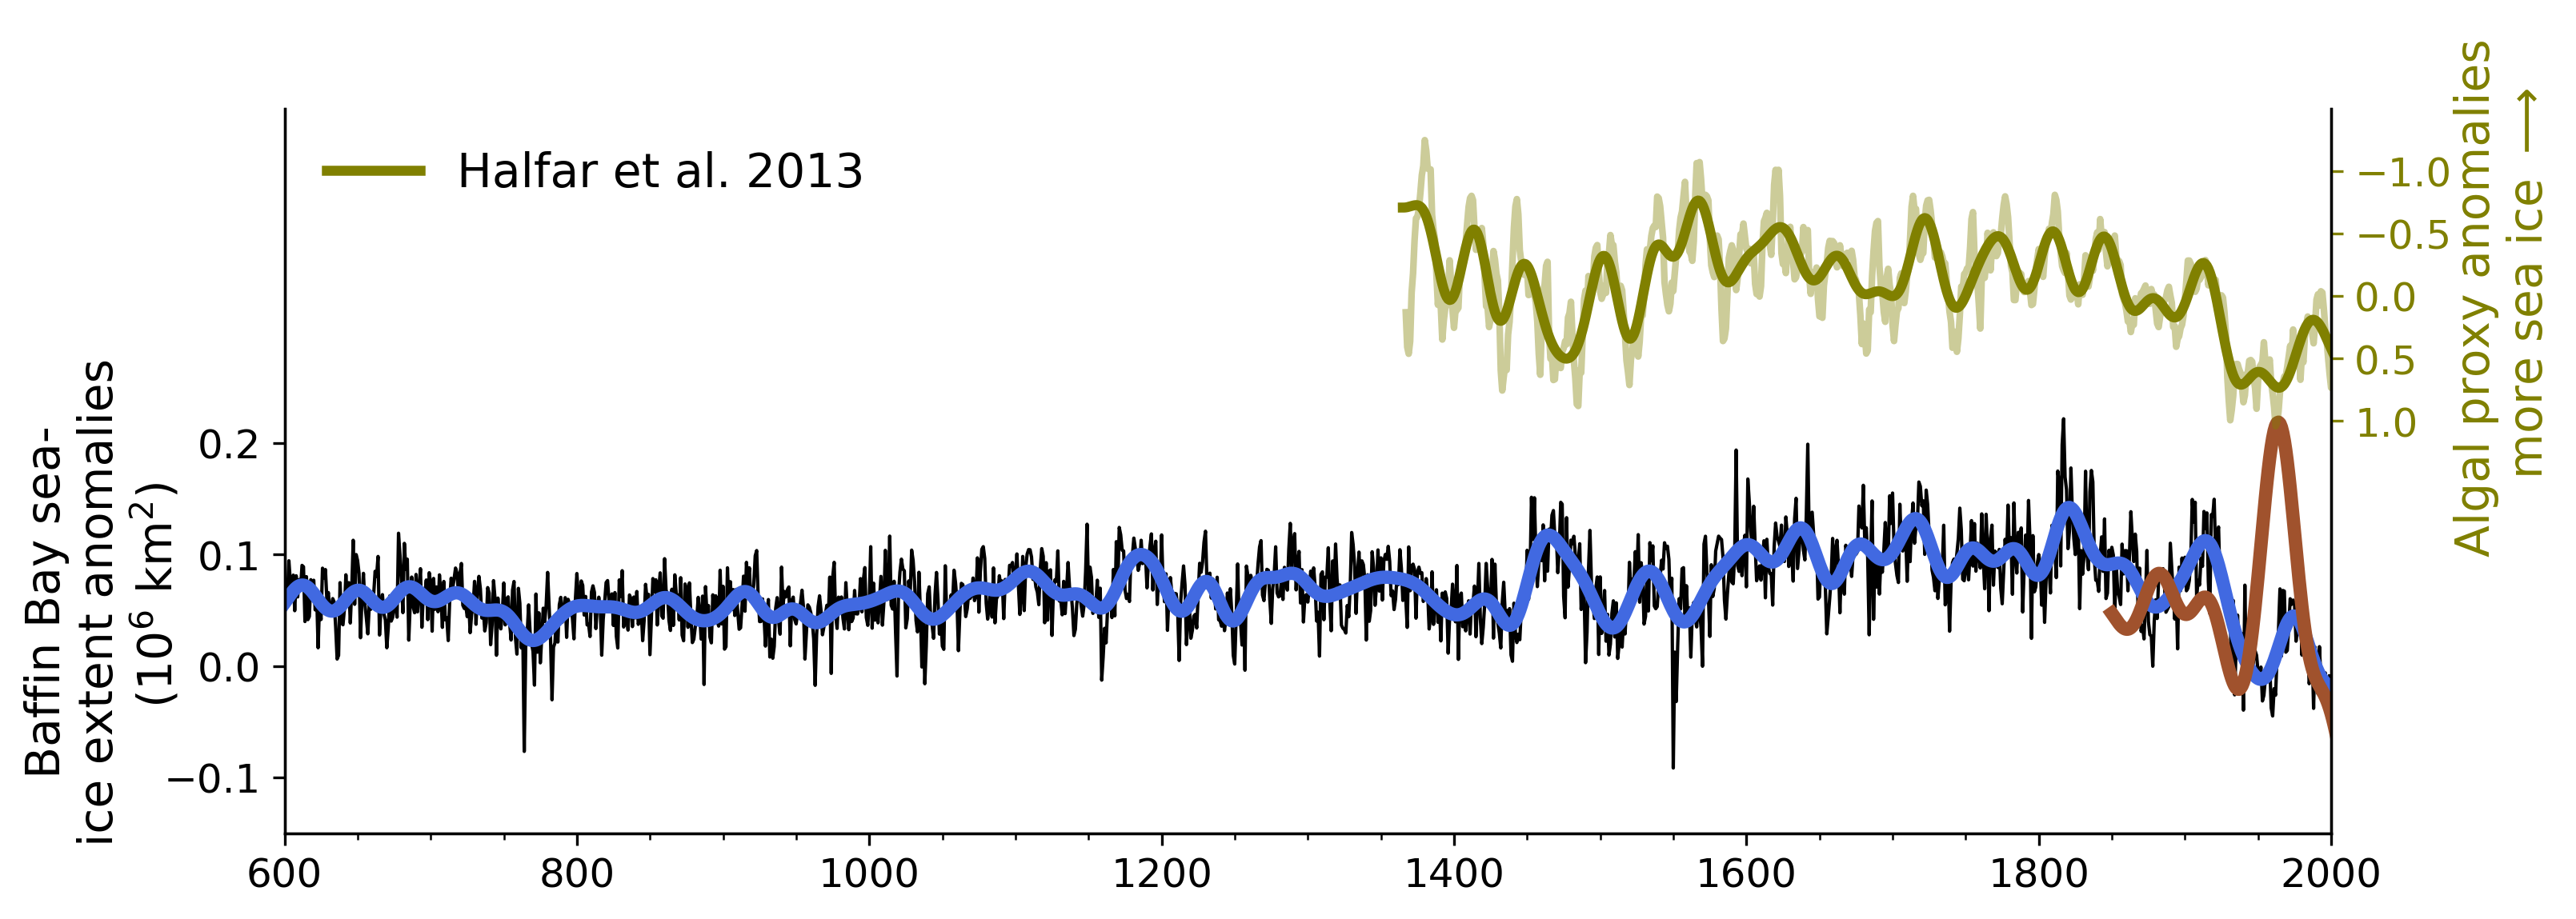

In [24]:
fig, ax_recon = plt.subplots(1, figsize=(11,4))


plt.plot(np.array(recon_years), sia_reg_anom_ccsm4[baffin_ind,:], 
         color='k',linewidth=1,label='Reconstruction - \nCCSM4, Pages2k')
plt.plot(np.array(recon_years), baffin_sia_filt15, 
         color='royalblue',linewidth=4,label='15 year filtered \nreconstruction')

plt.plot(walsh_time, baffin_walsh_filt15, color='sienna',linewidth=4,
         label='Walsh et al. 2019')

ax_proxy = ax_recon.twinx()
plt.plot(halfar_time[2:-2], halfar_sic_5ymn, color='olive',linewidth=2, alpha=0.4)
plt.plot(halfar_time, halfar_sic_filt15, color='olive',linewidth=3, label='Halfar et al. 2013')


ax_proxy.set_ylim(4.3,-1.5)
ax_recon.set_ylim(-0.15,0.5)
ax_proxy.set_xlim(600,2000)
ax_recon.set_xlim(600,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.1,0.21,0.1))
ax_proxy.set_yticks(np.arange(-1.0,1.1,0.5))

ax_proxy.set_ylabel('Algal proxy anomalies \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('Baffin Bay sea- \nice extent anomalies \n(10$^6$ km$^2$)', fontsize=14)

ax_proxy.yaxis.set_label_coords(1.06, 0.75)
ax_recon.yaxis.set_label_coords(-0.05, 0.33)

ax_proxy.yaxis.label.set_color('olive')
ax_proxy.tick_params(axis='y', colors='olive')

ax_proxy.legend(loc='upper left',frameon=False, fontsize=14)
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

# S9 Kinnard Comparison: 

In [25]:
kinnard_file = 'Kinnard_etal_2011_figure3.xls'

kinnard_df = pd.read_excel(io=data_dir+kinnard_file, skiprows=26)

In [26]:
kinnard_years = kinnard_df[1].values
kinnard_recon = kinnard_df[2].values/1e6
kinnard_recon_low = kinnard_df[3].values/1e6
kinnard_recon_high = kinnard_df[4].values/1e6

Bonnet_2010 = kinnard_df[6].values
Walsh_2001 = kinnard_df[7].values

Vare_2010 = kinnard_df[10].values
Vare_lat = 77 + 58.97/60
Vare_lon = (26 + 47.61/60)

Masse_2008 = kinnard_df[11].values
Masse_lat = 66 + 33.06/60
Masse_lon = 360 -(17 + 41.59/60)

deVernal_2008 = kinnard_df[8].values
deVernal_lat = 74.51
deVernal_lon = 360 - 159.9766667

Walsh_fram_2001 = kinnard_df[6]

In [27]:
Wn2 = 1.0/40
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

recon_sic_filt40 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_ccsm4)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [28]:
[ce_kinnard_ccsm4,
 corr_kinnard_ccsm4,_,_] = rrutils.find_ce_corr(kinnard_recon, 
                                                recon_sic_filt40,
                                                np.array(recon_years),
                                                kinnard_years,563,1995)

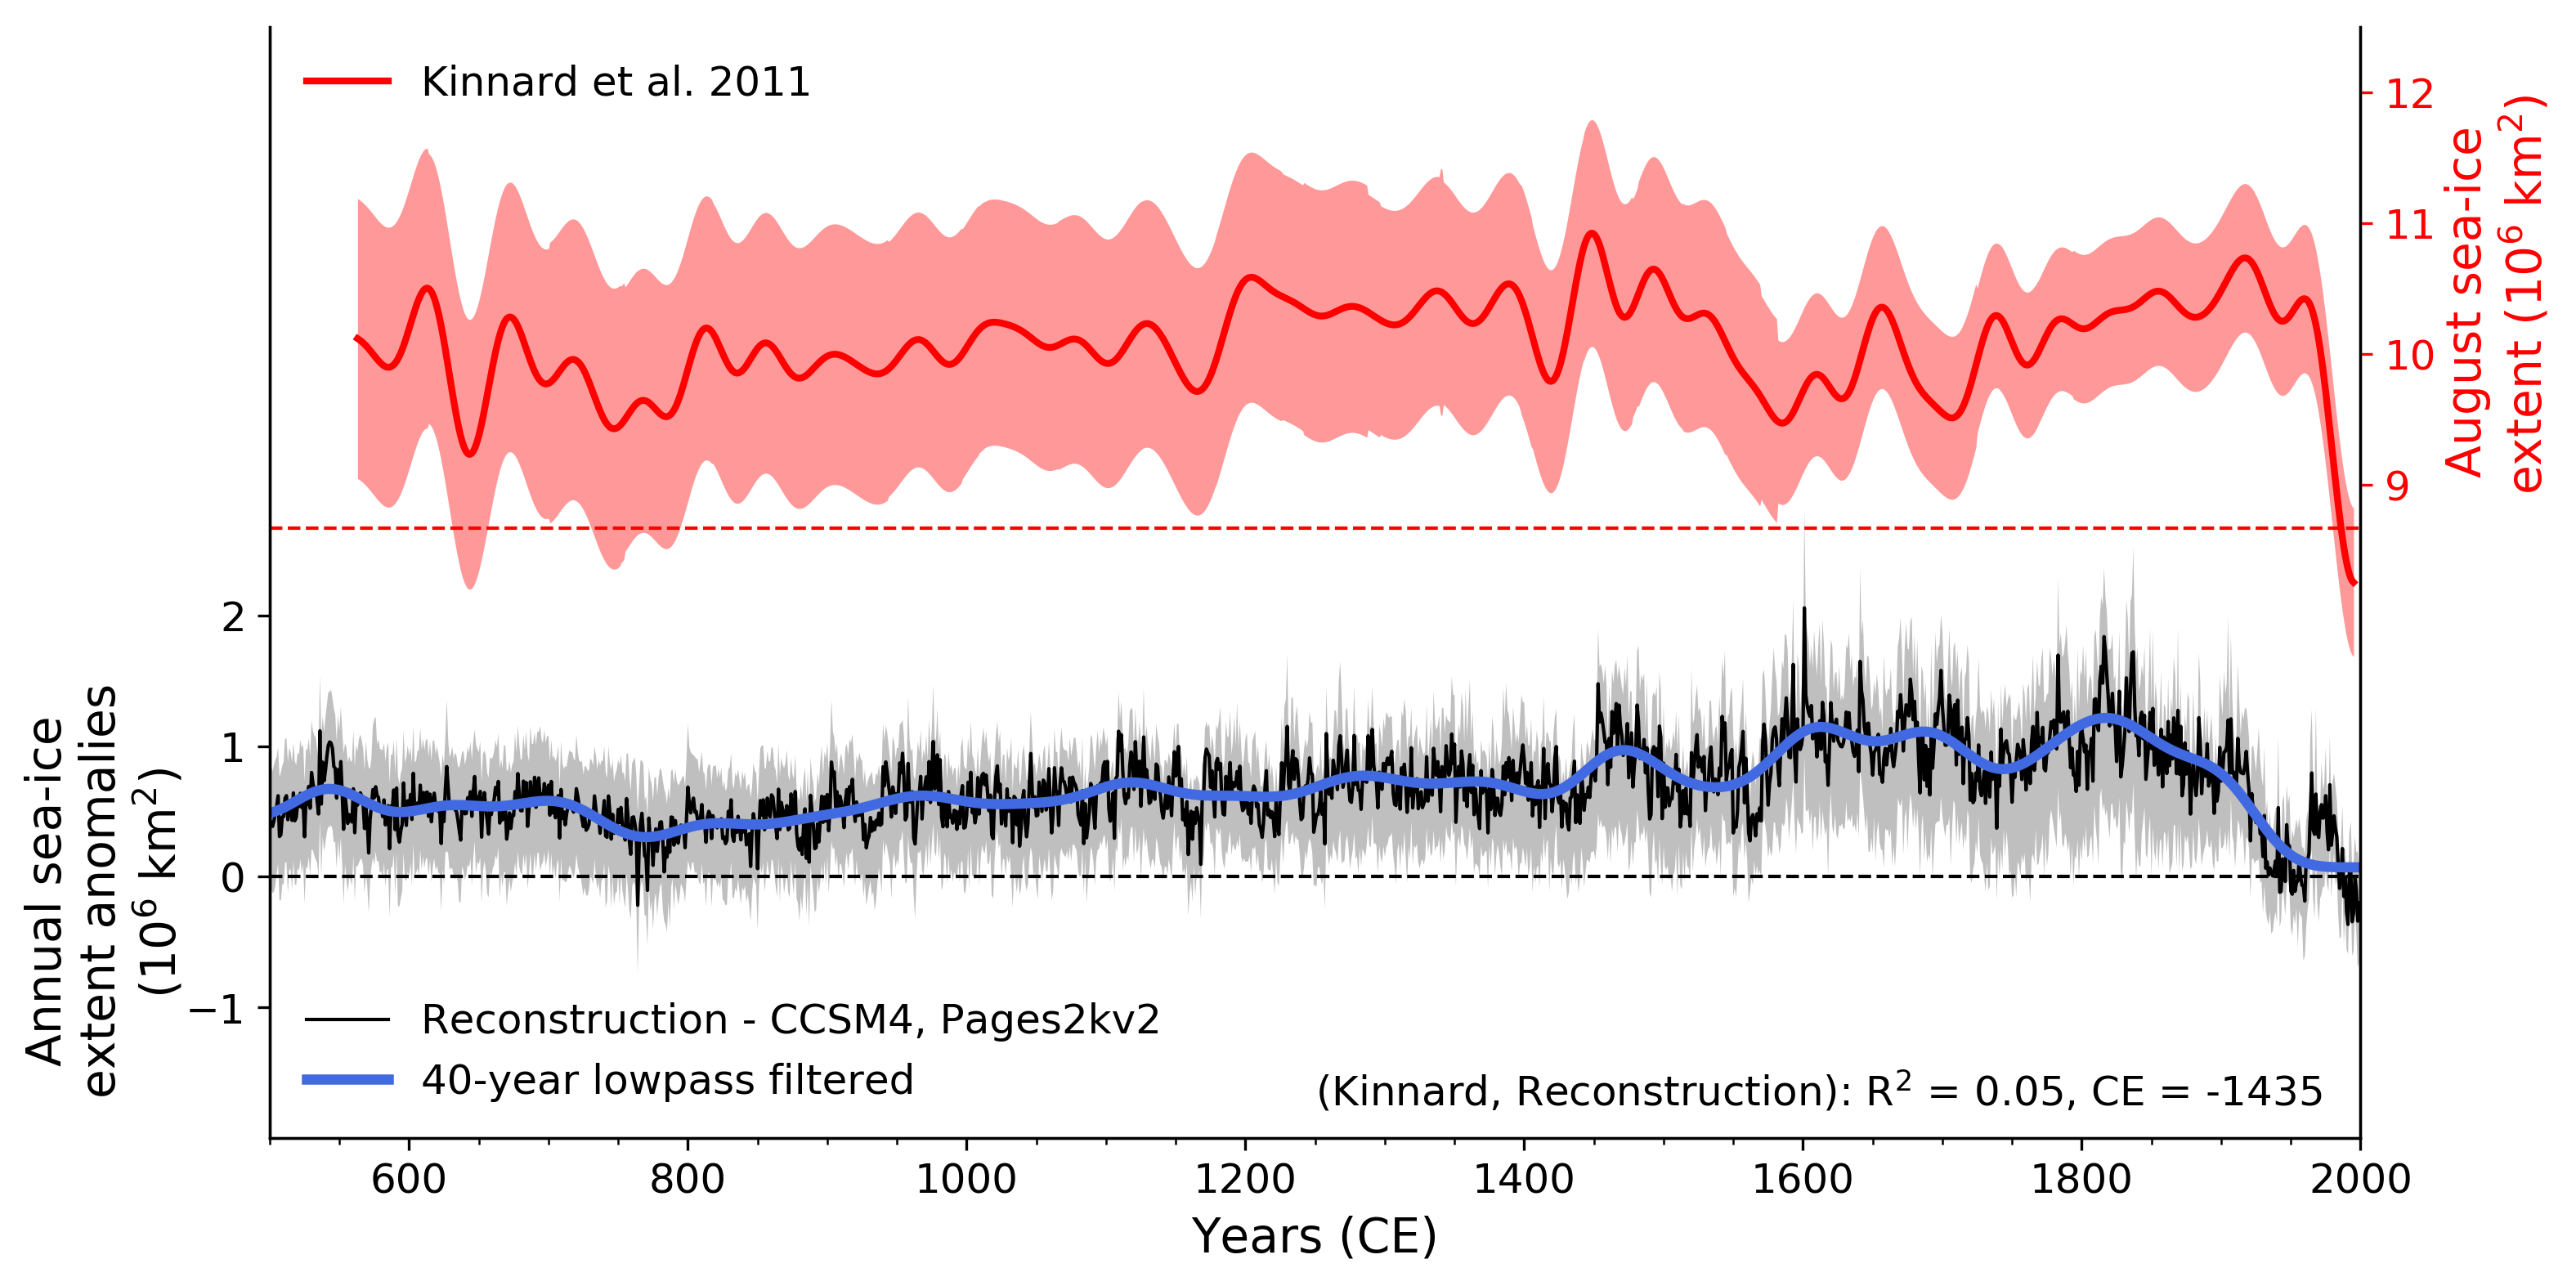

In [29]:
kinnard_sat_mean = np.nanmean(kinnard_recon[np.where((kinnard_years>=1979)&(kinnard_years<=2000))])

fig, ax_recon = plt.subplots(1, figsize=(11,6))

ax_recon.axhline(0,linestyle='--',color='k', linewidth=1)

ax_recon.fill_between(recon_years,sie_2_5_allit_ccsm4,sie_97_5_allit_ccsm4,
                      color='gray',lw=0.01,alpha=0.5)
ax_recon.plot(recon_years,sie_ensmn_anom_allit_ccsm4,color='k',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=1)
ax_recon.plot(recon_years,recon_sic_filt40,color='royalblue',
         label='40-year lowpass filtered',linewidth=3)

ax_proxy = ax_recon.twinx()
ax_proxy.axhline(kinnard_sat_mean,linestyle='--',color='r', linewidth=1)
ax_proxy.plot(kinnard_years,kinnard_recon,color='r', linewidth=2, label='Kinnard et al. 2011')
ax_proxy.fill_between(kinnard_years,kinnard_recon_low,kinnard_recon_high, alpha=0.4, color='r',lw=0.01)

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(4,12.5)
ax_recon.set_ylim(-2,6.5)
ax_proxy.set_xlim(500,2000)
ax_recon.set_xlim(500,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-1,3,1))
ax_proxy.set_yticks(np.arange(9,13,1))

ax_proxy.set_ylabel('August sea-ice \nextent (10$^6$ km$^2$)', fontsize=14)
ax_recon.set_ylabel('Annual sea-ice \nextent anomalies \n(10$^6$ km$^2$)', fontsize=14)
ax_recon.set_xlabel('Years (CE)', fontsize=14)
#plt.title('Barents Sea: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.04, 0.76)
ax_recon.yaxis.set_label_coords(-0.04, 0.23)

ax_proxy.legend(loc='upper left',frameon=False, fontsize=12)
ax_recon.legend(loc='lower left',frameon=False, fontsize=12)
#ax_recon.legend(bbox_to_anchor=[0.0,0.54],frameon=False, fontsize=14)

#ax_proxy.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

ax_proxy.yaxis.label.set_color('r')
ax_proxy.tick_params(axis='y', colors='r')

ax_recon.text(1250,-1.75,('(Kinnard, Reconstruction): R$^2$ = '+str(np.round(corr_kinnard_ccsm4**2,2))+
                         ', CE = '+str(int(ce_kinnard_ccsm4))),fontsize=12)

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Kinnard_comparison_ccsm4.png'
plt.savefig(savedir+savename)

## Barents Sea Comparison: Vare et al 2010 

In [30]:
for i in range(len(regions)):
    if 'Barents Sea' in regions[i]:
        barents_ind = i 

In [31]:
[ce_barents_walsh_ccsm4,
 corr_barents_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_regional_sia['Barents Sea'], 
                                                     sia_reg_anom_ccsm4[barents_ind,:],
                                                     np.array(recon_years),
                                                     walsh_time,1850,1999)

In [32]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

barents_sic_filt20 = signal.filtfilt(b2,a2,sia_reg_anom_ccsm4[barents_ind,:])
barents_walsh_filt20 = signal.filtfilt(b2,a2,walsh_regional_sia['Barents Sea'])

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


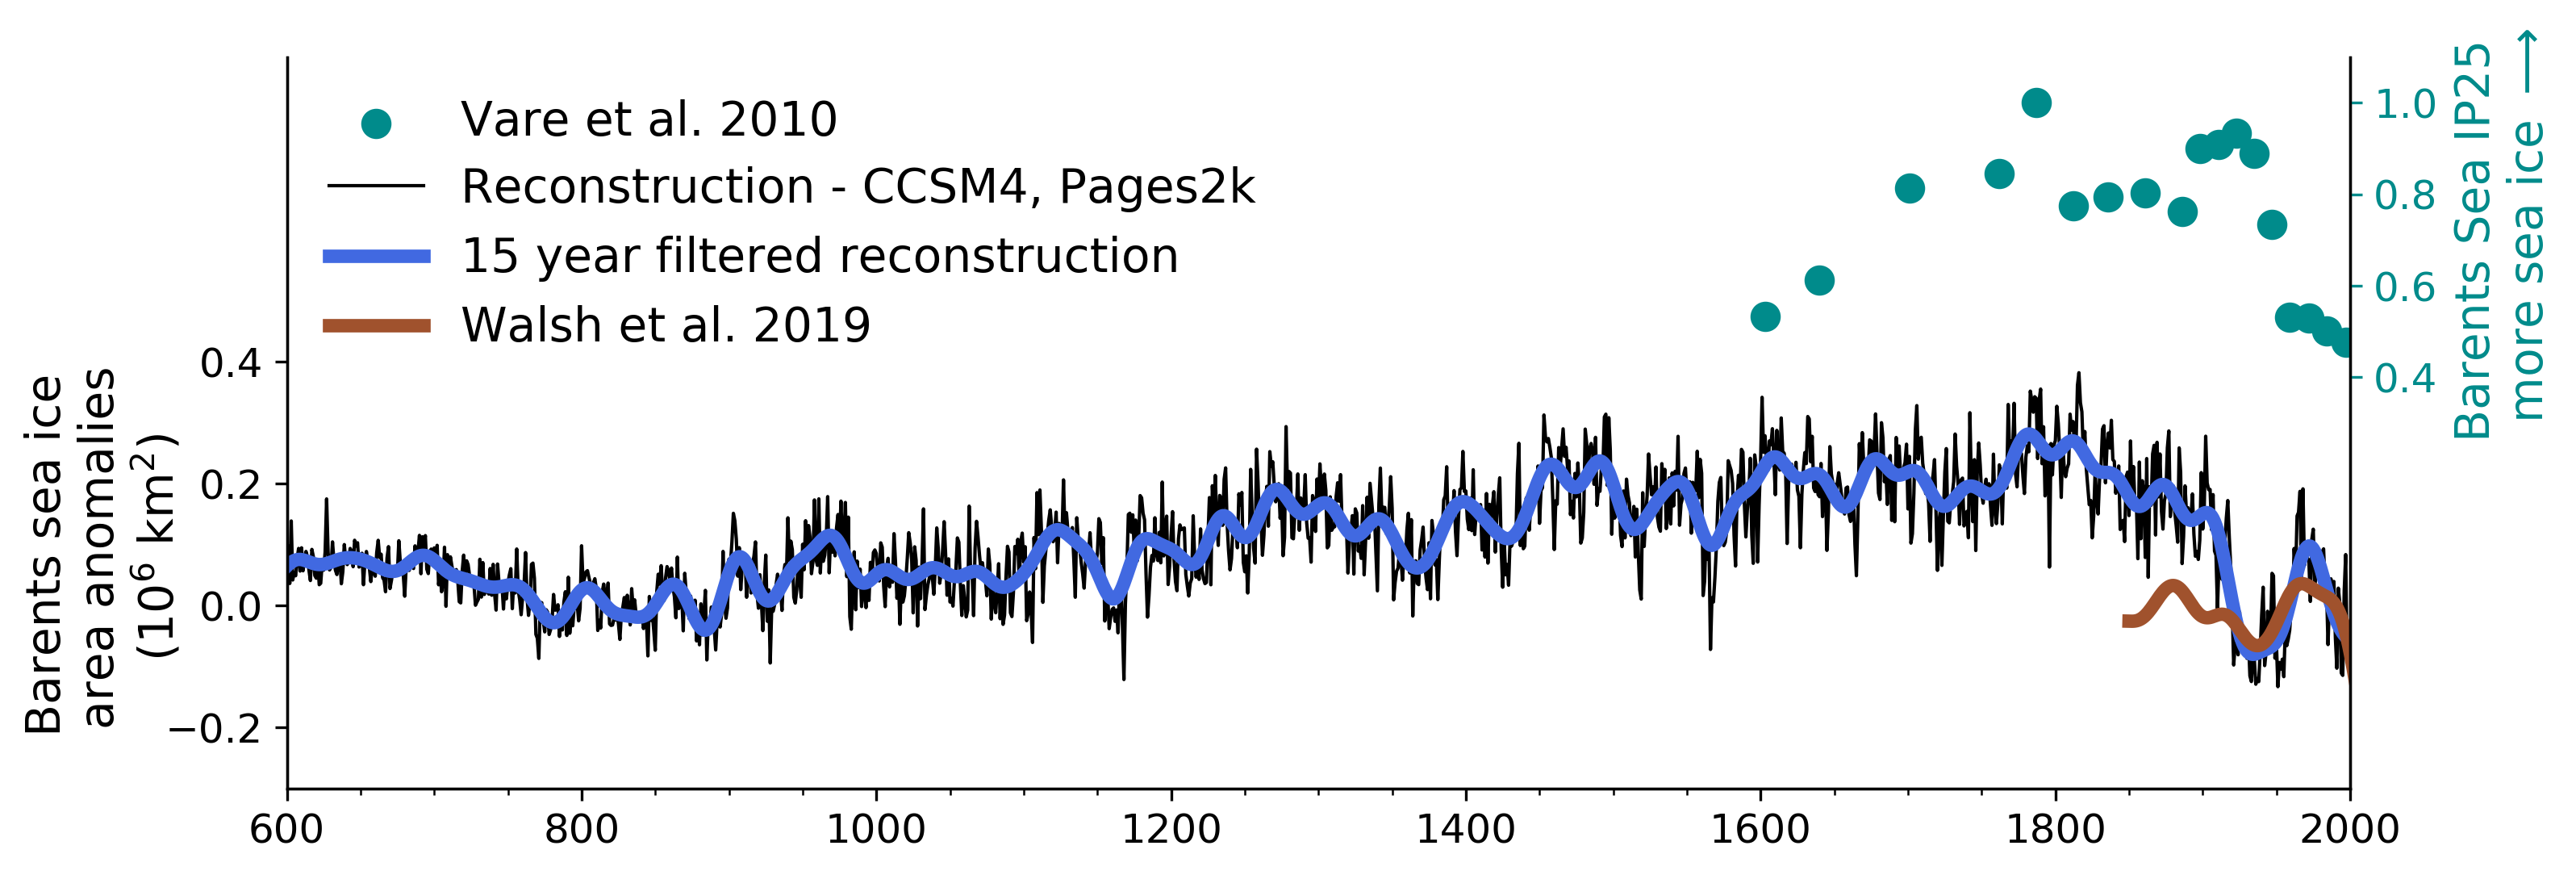

In [42]:
fig, ax_recon = plt.subplots(1, figsize=(11,4))
min_yr = 563

plt.plot(np.flip(kinnard_years[9:]), sia_reg_anom_ccsm4[barents_ind,min_yr:], color='k',linewidth=1,
         label='Reconstruction - CCSM4, Pages2k')
plt.plot(np.flip(kinnard_years[9:]), barents_sic_filt20[min_yr:], color='royalblue',linewidth=4,
         label='15 year filtered reconstruction')
# plt.fill_between(np.flip(kinnard_years[9:]),barents_sic_lowanom[min_yr:],
#                  barents_sic_highanom[min_yr:],color='gray',alpha=0.5, edgecolor=None)

plt.plot(walsh_time, barents_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')

ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years[9:], Vare_2010[9:], color='darkcyan',linewidth=3, label='Vare et al. 2010')

#plt.ylim(1.5,-1.5)

ax_proxy.set_ylim(-0.5,1.1)
ax_recon.set_ylim(-0.3,0.9)
ax_proxy.set_xlim(600,2000)
ax_recon.set_xlim(600,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.2,0.4,0.2))
ax_proxy.set_yticks(np.arange(0.4,1.1,0.2))

ax_proxy.set_ylabel('Barents Sea IP25 \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('Barents sea ice \narea anomalies\n(10$^6$ km$^2$)', fontsize=14)
#plt.title('Barents Sea: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.05, 0.76)
ax_recon.yaxis.set_label_coords(-0.05, 0.33)

ax_proxy.legend(loc='upper left',frameon=False, fontsize=14)
ax_recon.legend(bbox_to_anchor=[0.0,0.54],frameon=False, fontsize=14)

#ax_proxy.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))

ax_proxy.yaxis.label.set_color('darkcyan')
ax_proxy.tick_params(axis='y', colors='darkcyan')

# ax_recon.text(620,-0.25,('(Walsh, Reconstruction): R$^2$ = '+str(np.round(corr_barents_walsh_ccsm4**2,2))+
#                          ' CE = '+str(np.round(ce_barents_walsh_ccsm4,2))),fontsize=12)

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

# ax_recon.axvline(1940)
# ax_recon.axvline(1920)

## Northern Iceland Comparison: Masse et al. 2008 

In [43]:
for i in range(len(regions)):
    if 'East Greenland' in regions[i]:
        green_ind = i 

In [44]:
Wn2 = 1.0/15
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)

fram_sic_filt20 = signal.filtfilt(b2,a2,sia_reg_anom_ccsm4[green_ind,:])
fram_walsh_filt20= signal.filtfilt(b2,a2,walsh_regional_sia['East Greenland Sea'])

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [45]:
[ce_fram_walsh_ccsm4,
 corr_fram_walsh_ccsm4,_,_] = rrutils.find_ce_corr(walsh_regional_sia['East Greenland Sea'], 
                                                   sia_reg_anom_ccsm4[green_ind,:],
                                                   np.array(recon_years),
                                                   walsh_time,1850,1999)

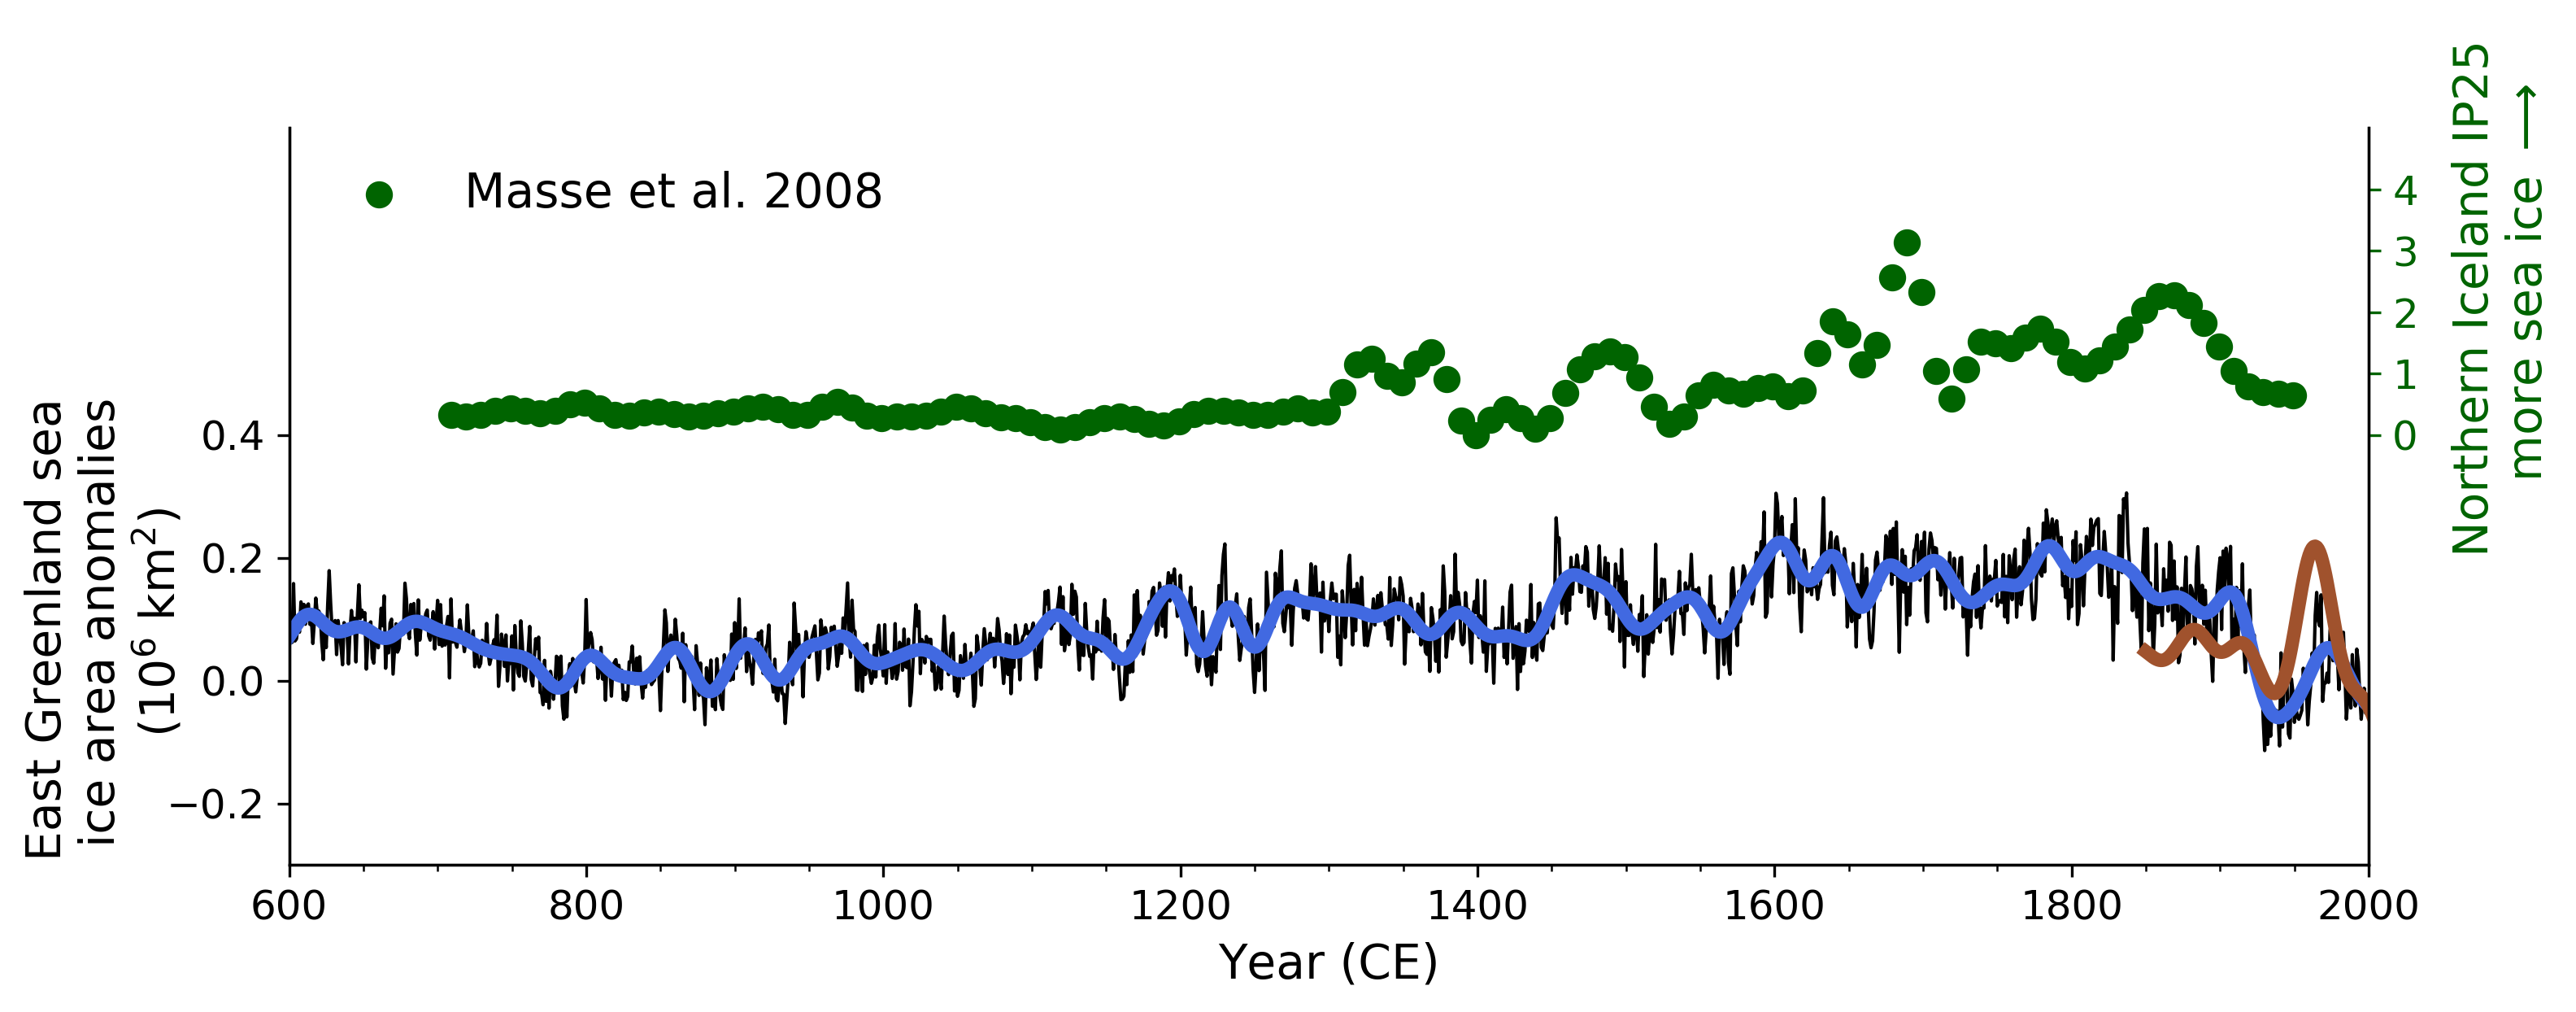

In [46]:
fig, ax_recon = plt.subplots(1, figsize=(11,4))

plt.plot(np.flip(kinnard_years[9:]), sia_reg_anom_ccsm4[green_ind,min_yr:], color='k',linewidth=1,
        label='Reconstruction - CCSM4, Pages2k')
plt.plot(np.flip(kinnard_years[9:]), fram_sic_filt20[min_yr:], color='royalblue',linewidth=4,
         label='15 year filtered reconstruction')
# plt.fill_between(np.flip(kinnard_years[9:]),fram_sic_lowanom[min_yr:],
#                  fram_sic_highanom[min_yr:],color='gray',alpha=0.5, edgecolor=None)

plt.plot(walsh_time, fram_walsh_filt20, color='sienna',linewidth=4,
         label='Walsh et al. 2019')

ax_proxy = ax_recon.twinx()
plt.scatter(kinnard_years, Masse_2008, color='darkgreen',linewidth=2, label='Masse et al. 2008')

ax_proxy.set_ylim(-7,5)
ax_recon.set_ylim(-0.3,0.9)
ax_proxy.set_xlim(600,2000)
ax_recon.set_xlim(600,2000)

ax_recon.spines['top'].set_visible(False)
ax_proxy.spines['top'].set_visible(False)

ax_recon.set_yticks(np.arange(-0.2,0.4,0.2))
ax_proxy.set_yticks(np.arange(0,4.1,1))

ax_proxy.set_ylabel('Northern Iceland IP25 \n more sea ice $\longrightarrow$', fontsize=14)
ax_recon.set_ylabel('East Greenland sea \nice area anomalies\n(10$^6$ km$^2$)', fontsize=14)
ax_recon.set_xlabel('Year (CE)', fontsize=14)
#plt.title('Northern Iceland: Regional Comparison', fontsize=16)

ax_proxy.yaxis.set_label_coords(1.04, 0.78)
ax_recon.yaxis.set_label_coords(-0.05, 0.33)

ax_proxy.yaxis.label.set_color('darkgreen')
ax_proxy.tick_params(axis='y', colors='darkgreen')

#ax_proxy.legend(bbox_to_anchor=[0.305,1.05],frameon=False, fontsize=14)
ax_proxy.legend(loc = 'upper left',frameon=False, fontsize=14)
#ax_recon.legend(bbox_to_anchor=[0.49,0.965],frameon=False, fontsize=14)

#ax_recon.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_recon.xaxis.set_minor_locator(MultipleLocator(50))
# ax_recon.text(620,-0.25,('(Walsh, Reconstruction): R$^2$ = '+str(np.round(corr_fram_walsh_ccsm4**2,2))+
#                          ' CE = '+str(np.round(ce_fram_walsh_ccsm4,2))),fontsize=12)

ax_recon.tick_params(axis='both', which='major', labelsize=12)
ax_proxy.tick_params(axis='both', which='major', labelsize=12)

# ax_recon.axhline(0)
# ax_proxy.axhline(0)
# ax_recon.axvline(1300)